# Lecture #8: Bayesian Latent Variable Models and Variational Inference
## AM 207: Advanced Scientific Computing
### Stochastic Methods for Data Analysis, Inference and Optimization
### Fall, 2019

<img src="fig/logos.jpg" style="height:150px;">

In [1]:
### Import basic libraries
import numpy as np
import scipy as sp
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

## Administrative Matters

1. **Attendance Quiz:** <br><br>

## Outline
1. Review of MLE for Latent Variable Models
2. Bayesian Latent Variable Models
3. Coordinate Ascent Variational Inference
4. Bayesian Gaussian Mixture Models

# Review of MLE for Latent Variable Models

## Review: Latent Variable Models

Models that include an observed variable $Y$ and at least one unobserved variable $Z$ are called ***latent variable models***. In general, our model can allow $Y$ and $Z$ to interact in many different ways. We have studied models with one type of interaction:

<img src="fig/graphical_model.jpg" style="height:200px;">

We treat the parameters $\theta$ and $\phi$ as *unknown constants*, and we estimate them from the observed data $y_1, \ldots, y_N$.

### Example: Gaussian Mixture Models (GMMs)

In a ***Gaussian Mixture Model (GMM)***, we posit that the observed data $Y$ is generated by a mixture, $\pi=[\pi_1, \ldots, \pi_K]$, of $K$ number of Gaussians with means $\mu = [\mu_1, \ldots, \mu_K]$ and covariances $\Sigma = [\Sigma_1, \ldots, \Sigma_K]$. For each observation $Y_n$ the class of the observation $Z_n$ is a latent variable that indicates which of the $K$ Gaussian is responsible for generating $Y_n$:

\begin{aligned}
Z_n &\sim Cat(\pi),\\
Y_n | Z_n&\sim \mathcal{N}(\mu_{Z_n}, \Sigma_{Z_n}),
\end{aligned}
where $n=1, \ldots, N$ and $\sum_{k=1}^K \pi_k = 1$. 


GMMs are examples of ***model based clustering*** - breaking up a data set into natural clusters based on a statistical model fitted to the data.

Inference for this model may mean that we want to learn the mean and covariance for each class in the mixture. Or we may want to infer the class membership $z_n$ for each observation $y_n$.

### Maximum Likelihood Estimate Inference for Latent Variable Models

If we are interested in computing the maximum likelihood estimators of the parameters $\theta$ and $\phi$, we need to compute them with respect to the ***observed likelihood*** $p(y| \theta, \phi)$ - this is simply because we don't have access to the latent variable values, so we can't evaluate $p(y, z| \theta, \phi)$ given values for $\theta$ and $\phi$. 

Just like from before, we maximize the log-likelihood rather than the likelihood due to the simplifying properties of the log function:

$$
\theta^*, \phi^* = \underset{\theta, \phi}{\text{argmax}}\; \ell_y(\theta, \phi) = \underset{\theta, \phi}{\text{argmax}}\; \log p(y| \theta, \phi) = \underset{\theta, \phi}{\text{argmax}}\;\log \int p(y, z| \theta, \phi)\, dz
$$

Maximizing the the above requires taking a gradient,

$$
\nabla_{\theta, \phi} \log \int p(y, z| \theta, \phi)\, dz
$$

but it's not clear how to evaluate this expression. Rewriting the integral as an expectation, it turns out, illuminates the source of the problem:

$$
\nabla_{\theta, \phi} \log \int p(y, z| \theta, \phi)\, dz = \nabla_{\theta, \phi} \log \int p(y| z,  \phi)p(z|\theta)\, dz = \nabla_{\theta, \phi} \log \mathbb{E}_{z\sim p(z|\theta)}[p(y| z,  \phi)] = \frac{\nabla_{\theta, \phi} \mathbb{E}_{z\sim p(z|\theta)}[p(y| z,  \phi)]}{\mathbb{E}_{z\sim p(z|\theta)}[p(y| z,  \phi)]},\quad \text{(chain rule)}
$$

The above makes it clear that the gradient is not trivial to compute -- the gradient cannot be pushed into the expectation, since the distribution with respect to which we are taking the expectation depends on the optimization variable $\theta$. 

To make the gradient computation easier, we make two changes:

1. we introduce an auxiliary variable $q(z)$ so that we can replace $\mathbb{E}_{z\sim p(z|\theta)}$ with $\mathbb{E}_{z\sim q(z)}$. Note then the latter expectation no longer depends on $\theta$.

2. we push the log inside the expectation using Jensen's inequality.

That is, 
\begin{aligned}
\ell_y(\theta, \phi) &= \log \int p(y, z| \theta, \phi)\, dz\\
&= \log \int \frac{p(y, z| \theta, \phi)}{q(z)}q(z)\, dz\\
&= \log \mathbb{E}_{z\sim q(z)}\left[\frac{p(y, z| \theta, \phi)}{q(z)}\right]\\
&\geq \underbrace{\mathbb{E}_{z\sim q(z)} \left[\log\left(\frac{p(y, z| \theta, \phi)}{q(z)}\right)\right]}_{ELBO(\theta, \phi, q)}
\end{aligned}

We have dervied that $ELBO(\theta, \phi, q)$ is a lower bound of the log-likelihood $\ell_y(\theta, \phi)$, for any choice of $q$. So rather than maximizing the log-likelihood, we maximize the $ELBO(\theta, \phi, q)$, thus ensuring that $\ell_y(\theta, \phi)$ is at least as big:

$$
\underset{\theta, \phi}{\max}\ell_y(\theta, \phi)\geq \underset{\theta, \phi, q}{\max}ELBO(\theta, \phi, q)
$$

In order to maximize the ELBO, we use coordinate ascent. That is, we take turns maximizing the ELBO with respect to $q$ and then with repect to $\theta, \phi$.

This algorithm is called ***expectation maximization (EM)***.

## The Expectation Maximization Algorithm

The ***exepectation maximization (EM) algorithm*** maximize the ELBO of the model,
<img src="fig/graphical_model.jpg" style="height:150px;">
0. **Initialization:** Pick $\theta_0$, $\phi_0$.
1. Repeat $i=1, \ldots, I$ times:

  **E-Step:** 
$$q_{\text{new}}(Z_n) = \underset{q}{\mathrm{argmax}}\; ELBO(\theta_{\text{old}}, \phi_{\text{old}}, q) = p(Z_n|Y_n, \theta_{\text{old}}, \phi_{\text{old}})$$

  **M-Step:** 
  \begin{aligned}
  \theta_{\text{new}}, \phi_{\text{new}} &= \underset{\theta, \phi}{\mathrm{argmax}}\; ELBO(\theta, \phi, q_{\text{new}})\\
  &= \underset{\theta, \phi}{\mathrm{argmax}}\; \sum_{n=1}^N\mathbb{E}_{Z_n\sim p(Z_n|Y_n, \theta_{\text{old}}, \phi_{\text{old}})}\left[\log \left( p(y_n, Z_n | \phi, \theta\right) \right].
\end{aligned}

## Example: EM for the Gaussian Mixture Model of Birth Weight
The Gaussian mixture model for the birth weight data has 3 Gaussians with meand $\mu = [\mu_1, \mu_2, \mu_3]$ and variances $\sigma^2 = [\sigma_1^2, \sigma_2^2, \sigma_3^2]$, and the model is defined as:
\begin{aligned}
Z_n &\sim Cat(\pi),\\
Y_n &\sim \mathcal{N}(\mu_{Z_n}, \sigma^2_{Z_n}),
\end{aligned}
where $n=1, \ldots, N$ and $\sum_{k=1}^3 \pi_k = 1$. 

### The E-Step

The E-step in EM computes the distribution:
$$q_{\text{new}}(Z_n) = \underset{q}{\mathrm{argmax}}\; ELBO(\mu_{i-1}, \sigma^2_{i-1}, \pi_{i_1}, q) = p(Z_n|Y_n, \mu_{\text{old}}, \sigma^2_{\text{old}}, \pi_{\text{old}}).$$ 
Since $Z_n$ is a label, $p(Z_n|Y_n, \ldots)$ is a categorical distribution, with the probability of $Z_n=k$ given by:

<img src="fig/E_eq1.jpg" style="height:90px;">

where $\mathcal{Z} = \sum_{k=1}^K \pi_{k, \text{old}}\,\mathcal{N}(y_n; \mu_{k, \text{old}}, \sigma^2_{k, \text{old}})$.

## Example: EM for the Gaussian Mixture Model of Birth Weight
### Setting Up the M-Step

The M-step in EM maximize the following: 
<img src="fig/M_eq1.jpg" style="height:90px;">

If we expand the expectation a little, we get:
<img src="fig/M_eq2.jpg" style="height:300px;">
We can maximize each Term #1 and Term #2 individually.

## Example: EM for the Gaussian Mixture Model of Birth Weight
### All Together

**Initialization:**
Pick any $\pi$, $\mu$, $\sigma^2$

**E-Step:**
Compute $r_{n, k} = \displaystyle\frac{\pi_{k, \text{old}}\,\mathcal{N}(y_n; \mu_{k, \text{old}}, \sigma^2_{k, \text{old}})}{\mathcal{Z}}$, where $\mathcal{Z} = \sum_{k=1}^K \pi_{k, \text{old}}\,\mathcal{N}(y_n; \mu_{k, \text{old}}, \sigma^2_{k, \text{old}})$.

**M-Step:**
Compute model parameters:
- $\mu_{\text{new}} = \frac{1}{ \sum_{n=1}^N r_{n, k}} \sum_{n=1}^N r_{n, k} y_n$

- $\sigma^2_{\text{new}} = \frac{1}{ \sum_{n=1}^N r_{n, k}} \sum_{n=1}^N r_{n, k} (y_n - \mu_{\text{new}})^2$

- $\pi_{\text{new}} =  \frac{\sum_{n=1}^N r_{n, k}}{N}$

## Implementing EM for the Gaussian Mixture Model of Birth Weight

In [3]:
#Generate data
N = 2000
pis = [0.2, 0.6, 0.2]
mus = [4.3, 6, 7.8]
sigmas = [0.5**2, 0.7**2, 0.5**2]
K = 3
zs = np.random.choice(np.arange(K), size=N, p=pis)
y = np.array([np.random.normal(mus[z], sigmas[z]**0.5, 1)[0] for z in zs])

#initialization
mu_init = [2, 4, 5]
sigma_init = [2., 2., 2.]
pi_init = [0.33, 0.33, 0.33]

#implement EM
mu_current = mu_init
sigma_current = sigma_init
pi_current = pi_init

log_lkhd = []

total_iter = 1500
threshold = 1e-10

mu_diff = 1.
pi_diff = 1.
sigma_diff = 1.

i = 0

while i < total_iter and mu_diff > threshold and pi_diff > threshold and sigma_diff > threshold:
    #E-step
    r_unnormalized = np.array([(pi_current[k] *  sp.stats.norm(mu_current[k], sigma_current[k]**0.5).pdf(y)) for k in range(K)]).T
    r = r_unnormalized / r_unnormalized.sum(axis=1).reshape((-1, 1))
    #M-step
    mu_next = np.array([1. / r[:, k].sum() * (r[:, k] * y).sum() for k in range(K)])
    sigma_next = np.array([1. / r[:, k].sum() * (r[:, k] * (y - mu_next[k])**2).sum() for k in range(K)])
    pi_next = r.sum(axis=0) / r.shape[0]
    
    #compute log observed likelihood
    if i % 100 == 0:
        print('iteration ', i)
        ll = 0
        for n in range(len(y)):
            ll += np.log(np.sum([sp.stats.norm(mu_next[k], sigma_next[k]**0.5).pdf(y[n]) * pi_next[k] for k in range(K)])) 
        log_lkhd.append(ll)
        
    #convergence check
    mu_diff = np.linalg.norm(mu_next - mu_current)
    pi_diff = np.linalg.norm(pi_next - pi_current)
    sigma_diff = np.linalg.norm(sigma_next - sigma_current)
           
    #update parameters
    mu_current = mu_next
    sigma_current = sigma_next
    pi_current = pi_next
    i += 1
    
x = np.linspace(y.min(), y.max(), 100)

iteration  0
iteration  100
iteration  200
iteration  300
iteration  400
iteration  500
iteration  600
iteration  700
iteration  800
iteration  900


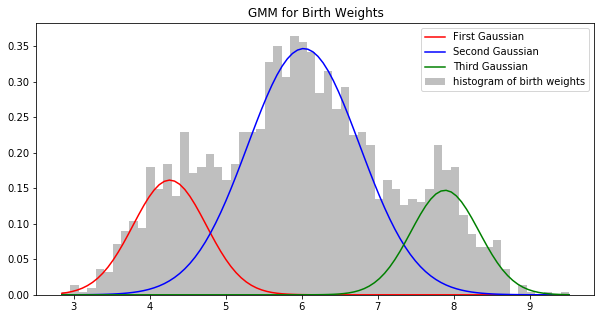

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist(y, bins=60, density=True, color='gray', alpha=0.5, label='histogram of birth weights')
ax.plot(x, pi_current[0] * sp.stats.norm(mu_current[0], sigma_current[0]**0.5).pdf(x), color='red', label='First Gaussian')
ax.plot(x, pi_current[1] * sp.stats.norm(mu_current[1], sigma_current[1]**0.5).pdf(x), color='blue', label='Second Gaussian')
ax.plot(x, pi_current[2] * sp.stats.norm(mu_current[2], sigma_current[2]**0.5).pdf(x), color='green', label='Third Gaussian')
ax.set_title('GMM for Birth Weights')
ax.legend(loc='best')
plt.show()

## Sanity Check: Log-Likelihood During Training

Remember that ploting the MLE model against actual data is not always an option (e.g. high-dimensional data).

A sanity check for that your EM algorithm has been implemented correctly is to plot the observed data log-likelihood over the iterations of the algorithm:
$$
\ell_y(\mu, \sigma^2, \pi) = \sum_{n=1}^N \log \sum_{k=1}^K \mathcal{N}(y_n; \mu_k, \sigma_k^2) \pi_k
$$

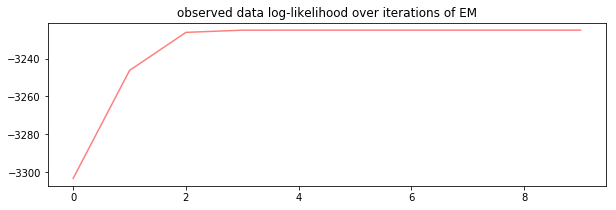

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(range(len(log_lkhd)), log_lkhd, color='red', alpha=0.5)
ax.set_title('observed data log-likelihood over iterations of EM')
plt.show()

# Bayesian Latent Variable Models

## Bayesian Latent Variable Models
Overfitting is an always a concern when using MLE model parameters. We can mitigate the effect of outliers in the data on the model we learn by treating the parameters as random variables and placing priors on them. 

In a latent variable model, maximum liklihood inference treats parameters $\theta$, $\phi$ as unknown constants and produces point-estimates for them. In a Bayesian latent variable model, $\theta$, $\phi$ are random variables and we derive the posterior distribution over them.

<img src="fig/bayesian_model.jpg" style="height:220px;">


That is, we want to infer 
$$p(\theta, \phi, Z_1, \ldots, Z_N|Y_1, \ldots, Y_N, a, b) = \frac{p(\theta | a)p(\phi|b)\prod_{n}p(Y_n|Z_n, \phi)p(Z_n|\theta)}{\prod_{n} p(Y_n)}.$$

## Challenges in Bayesian Inference
Unfortunately, most Bayesian models with multiple types of random variables (like Bayesian latent variable models) have complex posteriors that do not match known distributions. ***Exact inference*** is not possible. 

Sampling from the posterior may not always be the best option because:

1. Convergence of samplers may be slow (due to high dimensionality of the distribution or multimodality)<br><br>

2. Samplers like Metropolis-Hastings requires evaluating the liklihood $\prod_n p(Y_n | Z_n, \phi)$ in each iteration, if the observed data is large ($N$ is in the millions), this computation is expensive.

## The Idea of Variational Inference

**Idea: (Approximate Inferenec)** Approximate the hard posterior $p(\theta, \phi, Z_1, \ldots, Z_N|Y_1, \ldots, Y_N)$ with a distribution $q$ that is easy to sample from (like a Gaussian). Any computation involving the posterior can now be done with $q$.

This approximation of $p(\theta, \phi, Z_1, \ldots, Z_N|Y_1, \ldots, Y_N)$ with a distribution $q$ is called ***variational inference***.
<img src="fig/variational.jpg" style="height:220px;">

## The Design of the Variational Objective

**Goal:** given a target posterior distribution $p(\psi | Y_1, \ldots, Y_N)$, $\psi \in \mathbb{R}^I$ we want to find a distribution $q(\psi |\lambda^*)$ in a family of distributions $Q = \{q(\psi |\lambda) | \lambda \in \Lambda \}$ such that $q(\psi |\lambda^*)$ best approximates $p$. 

**Design Choices:** we need to choose:

A. ***(Variational family)*** a family $Q$ of candidate distributions for approximating $p$. The members of $Q$ are called the ***variational distributions***.

  **Our Choice:**  we assume that the joint $q(\psi)$ factorizes completely over each dimension of $\psi$, i.e. $q(\psi)= \prod_{i=1}^I q(\psi_i | \lambda_i)$. This is called the ***mean field assumption***. Ehat can go wrong with this design choice?
  
B. ***(Divergence measure)*** a divergence measure to quantify the difference between $p$ and $q$.

  **Our Choice:** 
  $$D_{\text{KL}}(q(\psi | \lambda) \| p(\psi | Y_1, \ldots, Y_N)) = \mathbb{E}_{\psi \sim q(\psi|\lambda)}\left[\log\left( \frac{q(\psi | \lambda)}{p(\psi | Y_1, \ldots, Y_N)} \right) \right]$$
  What can go wrong with this design choice?
  

## Variational Inference as Optimization

We can now formalize the the problem of variational inference for a target distribution $p(\psi)$: 

Find a $q(\psi|\lambda^*)$ such that 

\begin{aligned}
\lambda^* = \underset{\lambda}{\text{argmin}}\; D_{\text{KL}}(q(\psi|\lambda) \| p(\psi|Y_1, \ldots, Y_N))) = \underset{\lambda}{\text{argmin}}\; \mathbb{E}_{\psi \sim q(\psi|\lambda)}\left[\log\left(\frac{q(\psi | \lambda)}{p(\psi|Y_1, \ldots, Y_N))}\right) \right]
\end{aligned}

Recall that for EM, we had proved that minimizing the KL is equivalent to maximizing the ELBO (for which it is easier to compute the gradient). We will do the same here:

\begin{aligned}
\underset{\lambda}{\min}D_{\text{KL}}(q(\psi|\lambda) \| p(\psi|Y_1, \ldots, Y_N))) &\overset{\text{equiv}}{\equiv} \underset{\lambda}{\max} -D_{\text{KL}}(q(\psi|\lambda) \| p(\psi|Y_1, \ldots, Y_N))) \\
&= \underset{\lambda}{\max} -\mathbb{E}_{\psi \sim q(\psi|\lambda)}\left[\log\left(\frac{q(\psi | \lambda)}{p(\psi|Y_1, \ldots, Y_N))} \right)\right] \\
&= \underset{\lambda}{\max}\underbrace{\mathbb{E}_{\psi \sim q(\psi|\lambda)}\left[\log\left(\frac{p(\psi, Y_1, \ldots, Y_N))}{q(\psi | \lambda)} \right)\right]}_{ELBO(\lambda)} - \log p(Y_1, \ldots, Y_N).
\end{aligned}

Thus, the variational objective can be rephrased as maximizing the $ELBO$.

## Gradients of the ELBO

Unfortunately, the ELBO for variational inference of the posterior does not have easy gradients,

\begin{aligned}
\nabla_{\lambda}\,\underbrace{\mathbb{E}_{\psi \sim q(\psi|\lambda)}\left[\log\left(\frac{p(\psi, Y_1, \ldots, Y_N)}{q(\psi | \lambda)} \right)\right]}_{ELBO(\lambda)}.
\end{aligned}

In particular, the issue is that the gradient taken is with respect to the parameter $\psi$ of the distribution over which we are taking the expectation - i.e. we cannot push the gradient into the expectation.

Today we will maximize the $ELBO$ using coordinate ascent (just as in the case of EM). But you'll see that ***coordinate ascent variational inference*** requires that we perform model specific computations (often in closed form). This restrict the class of Bayesian models for which we can perform variational inference.

Two of the major development we will cover later in the semester address how to estimate this gradient **efficiently and without bias**.

## Coordinate Ascent Variational Inference

## Maximizing the ELBO via Coordinate Ascent

The coordinate ascent algorithm maximizes an objective function $ELBO(\lambda)$ by iteratively maximizing over $\lambda_i$, holding constant $\lambda_{-i} = [\lambda_1\; \ldots\; \lambda_{i-1}\; \lambda_{i+1}\; \ldots\; \lambda_{I}]$.

The ***coordinate ascent variational inference algorithm***:
0. **Initialization:** pick an intial value $\lambda^{(0)}$
1. **Coordinate-wise maximization:** 

   Repeat for $j=1, \ldots, J$ iterations:

   $\quad\quad$ Cycle thru $i=1, \ldots, I$ coordinates:
  
$$q(\psi_i | \lambda^{\text{new}}_i) \propto \exp\left\{ \mathbb{E}_{\psi_{-i} \sim q(\phi_{-i} | \lambda^{\text{new}}_{1}, \ldots, \lambda^{\text{new}}_{i-1}, \lambda^{\text{old}}_{i+1}, \ldots, \lambda^{\text{old}}_{I})}\left[\log p(Y_1, \ldots, Y_N, \psi)\right]\right\}.$$
       
where $\psi_{-i} = [\psi_1\; \ldots\; \psi_{i-1}\; \psi_{i+1}\; \ldots\; \psi_{I}]$.

## Proof of the Update Rule for $q(\psi_i | \lambda^{\text{new}}_i)$

We want to show that $q(\psi_i | \lambda^{*}_i) \propto \exp\left\{ \mathbb{E}_{\psi_{-i} \sim q(\phi_{-i} | \lambda_{-i})}\left[\log p(Y_1, \ldots, Y_N, \psi_i | \psi_{-i})\right]\right\}$, where

$$
\lambda^{*}_i = \underset{\lambda}{\max}\underbrace{\mathbb{E}_{\psi \sim q(\psi|\lambda)}\left[\log\left(\frac{p(\psi, Y_1, \ldots, Y_N))}{q(\psi | \lambda)} \right)\right]}_{ELBO(\lambda)}.
$$

To maximize the $ELBO$, we will 

1. use the mean-field assumption to break up the expectation $\mathbb{E}_{\psi \sim q(\psi|\lambda)}$ into an interated expectation $\mathbb{E}_{\psi_i \sim q(\psi_i|\lambda_i)}\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})}$
2. we will rewrite the outer expectation $\mathbb{E}_{\psi_i \sim q(\psi_i|\lambda_i)}$ as a negative KL-divergence
3. we will maximize the negative KL-divergence by setting the two arguments of the divergence equal to each other

For the following, we will use the following notation:

\begin{aligned}
\lambda_{-i} &= [\lambda_1\; \ldots\; \lambda_{i-1}\; \lambda_{i+1}\; \ldots\; \lambda_{I}]\\
\psi_{-i} &= [\psi_1\; \ldots\; \psi_{i-1}\; \psi_{i+1}\; \ldots\; \psi_{I}]\\
q(\psi_{-i}|\lambda_{-i}) &= \prod_{j\neq i}q(\psi_{j}|\lambda_{j})\\
\Psi_{-i} &= \bigcup_{j\neq i} \Psi_j\\
d\psi_{-1} &= d(\psi_1, \ldots, \psi_{i-1}, \psi_{i+1}, \ldots, \psi_{I}
\end{aligned}


### Step 1: Show that $\mathbb{E}_{\psi \sim q(\psi|\lambda)}[\ldots] = \mathbb{E}_{\psi_i \sim q(\psi_i|\lambda_i)}\left[\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})}[\ldots] \right]$

For step 1, we rewrite the ELBO:

\begin{aligned}
\underbrace{\mathbb{E}_{\psi \sim q(\psi|\lambda)}\left[\log\left(\frac{p(\psi, Y_1, \ldots, Y_N))}{q(\psi | \lambda)} \right)\right]}_{ELBO(\lambda)} &= \int_{\Psi} \left[ \log \left(\frac{p(Y_1, \ldots, Y_N, \psi)}{q(\psi|\lambda)} \right)\right]q(\psi|\lambda) d\psi\\
&= \int_{\Psi_i} \int_{\Psi_{-i}} \left[ \log \left(\frac{p(Y_1, \ldots, Y_N, \psi_i | \psi_{-i})p(\psi_{-i})}{q(\psi_{i}|\lambda_{i})q(\psi_{-i}|\lambda_{-i})} \right)\right] q(\psi_{i}|\lambda_{i})q(\psi_{-i}|\lambda_{-i}) d\psi_{-i}d\psi_i\quad (\text{Fubini's Theorem})\\
&= \int_{\Psi_i} \left[\int_{\Psi_{-i}} \left[ \log \left(\frac{p(Y_1, \ldots, Y_N, \psi_i | \psi_{-i})p(\psi_{-i})}{q(\psi_{i}|\lambda_{i})q(\psi_{-i}|\lambda_{-i})} \right)\right] q(\psi_{-i}|\lambda_{-i}) d\psi_{-i} \right] q(\psi_{i}|\lambda_{i})d\psi_i\\
&= \mathbb{E}_{\psi_i \sim q(\psi_i|\lambda_i)}\left[\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})} \left[\log \left(\frac{p(Y_1, \ldots, Y_N, \psi_i | \psi_{-i})p(\psi_{-i})}{q(\psi_{i}|\lambda_{i})q(\psi_{-i}|\lambda_{-i})} \right)\right]\right]
\end{aligned}

Now we decompose the ELBO into terms containing $\lambda_i$, over which we are going to optimize, and terms not containing $\lambda_i$:

\begin{aligned}
ELBO(\lambda)&=\mathbb{E}_{\psi_i \sim q(\psi_i|\lambda_i)}\left[\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})} \left[\log \left(\frac{p(Y_1, \ldots, Y_N, \psi_i | \psi_{-i})p(\psi_{-i})}{q(\psi_{i}|\lambda_{i})q(\psi_{-i}|\lambda_{-i})} \right)\right]\right]\\
&= \mathbb{E}_{\psi_i \sim q(\psi_i|\lambda_i)}\left[\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})} \left[\log \left(\frac{p(Y_1, \ldots, Y_N, \psi_i | \psi_{-i})}{q(\psi_{i}|\lambda_{i})} \right) + \log\left(\frac{p(\psi_{-i})}{q(\psi_{-i}|\lambda_{-i})} \right)\right]\right]\\
&= \mathbb{E}_{\psi_i \sim q(\psi_i|\lambda_i)}\left[\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})} \left[\log \left(\frac{p(Y_1, \ldots, Y_N, \psi_i | \psi_{-i})}{q(\psi_{i}|\lambda_{i})} \right)\right]\right] + \mathbb{E}_{\psi_i \sim q(\psi_i|\lambda_i)}\left[\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})} \left[\log\left(\frac{p(\psi_{-i})}{q(\psi_{-i}|\lambda_{-i})} \right)\right]\right]\\
&= \mathbb{E}_{\psi_i \sim q(\psi_i|\lambda_i)}\left[\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})} \left[\log \left(\frac{p(Y_1, \ldots, Y_N, \psi_i | \psi_{-i})}{q(\psi_{i}|\lambda_{i})} \right)\right]\right] + \underbrace{\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})} \left[\log\left(\frac{p(\psi_{-i})}{q(\psi_{-i}|\lambda_{-i})} \right)\right]}_{\text{constant with respect to }\lambda_i}\\
\end{aligned}

Note that we don't need to consider the constant term when optimizing with respect to $\lambda_i$.

### Step 2: Show that $\underset{\lambda_i}{\max}\mathbb{E}_{\psi_i \sim q(\psi_i|\lambda_i)}[\ldots] \equiv \underset{\lambda_i}{\min} D_{\text{KL}}[\ldots]$

We show that maximizing the $ELBO$ with respect to $\lambda_{i}$ is equivalent to minimizing a KL-divergence:

\begin{aligned}
\underset{\lambda_i}{\max} ELBO(\lambda) &= \underset{\lambda_i}{\max} \mathbb{E}_{\psi_i \sim q(\psi_i|\lambda_i)}\left[\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})} \left[\log \left(\frac{p(Y_1, \ldots, Y_N, \psi_i | \psi_{-i})}{q(\psi_{i}|\lambda_{i})} \right)\right]\right]\\
&= \underset{\lambda_i}{\max} \mathbb{E}_{\psi_i \sim q(\psi_i|\lambda_i)}\left[\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})} \left[\log \left(p(Y_1, \ldots, Y_N, \psi_i | \psi_{-i}) \right)\right] - \mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})} \left[\log\left(q(\psi_{i}|\lambda_{i})\right)\right]\right]\\
&= \underset{\lambda_i}{\max} \mathbb{E}_{\psi_i \sim q(\psi_i|\lambda_i)}\left[\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})} \left[\log \left(p(Y_1, \ldots, Y_N, \psi_i | \psi_{-i}) \right)\right] - \log\left(q(\psi_{i}|\lambda_{i})\right)\right]\\
&= \underset{\lambda_i}{\max} \mathbb{E}_{\psi_i \sim q(\psi_i|\lambda_i)}\left[ \log \left(\exp\left\{\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})} \left[\log \left(p(Y_1, \ldots, Y_N, \psi_i | \psi_{-i}) \right)\right] - \log\left(q(\psi_{i}|\lambda_{i})\right)\right\}\right)\right]\quad (\text{adding both a log and an exp})\\
&= \underset{\lambda_i}{\max} \mathbb{E}_{\psi_i \sim q(\psi_i|\lambda_i)}\left[ \log \left(\frac{\exp\left\{\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})} \left[\log \left(p(Y_1, \ldots, Y_N, \psi_i | \psi_{-i}) \right)\right]\right\} } {\exp \left\{\log\left(q(\psi_{i}|\lambda_{i})\right)\right\}} \right)\right]\\
&= \underset{\lambda_i}{\max} \mathbb{E}_{\psi_i \sim q(\psi_i|\lambda_i)}\left[ \log \left(\frac{\exp\left\{\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})} \left[\log \left(p(Y_1, \ldots, Y_N, \psi_i | \psi_{-i}) \right)\right]\right\} } {q(\psi_{i}|\lambda_{i})} \right)\right]\\
&\equiv \underset{\lambda_i}{\min} -\mathbb{E}_{\psi_i \sim q(\psi_i|\lambda_i)}\left[ \log \left(\frac{\exp\left\{\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})} \left[\log \left(p(Y_1, \ldots, Y_N, \psi_i | \psi_{-i}) \right)\right]\right\} } {q(\psi_{i}|\lambda_{i})} \right)\right]\\
&= \underset{\lambda_i}{\min} \underbrace{\mathbb{E}_{\psi_i \sim q(\psi_i|\lambda_i)}\left[ \log \left(\frac{ q(\psi_{i}|\lambda_{i}) } {\exp\left\{\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})} \left[\log \left(p(Y_1, \ldots, Y_N, \psi_i | \psi_{-i}) \right)\right]\right\} } \right)\right]}_{\text{looks like a KL except the denominator is not a distribution}}\quad (\text{using the properties of log})\\
&= \underset{\lambda_i}{\min} \mathbb{E}_{\psi_i \sim q(\psi_i|\lambda_i)}\left[ \log \left(\frac{ \mathcal{Z} q(\psi_{i}|\lambda_{i}) } {\mathcal{Z}\exp\left\{\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})} \left[\log \left(p(Y_1, \ldots, Y_N, \psi_i | \psi_{-i}) \right)\right]\right\} } \right)\right],\quad (\mathcal{Z} \text{ normalizes the denominator})\\
&= \underset{\lambda_i}{\min} \mathbb{E}_{\psi_i \sim q(\psi_i|\lambda_i)}\left[ \log \left(\frac{  q(\psi_{i}|\lambda_{i}) } {\mathcal{Z}\exp\left\{\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})} \left[\log \left(p(Y_1, \ldots, Y_N, \psi_i | \psi_{-i}) \right)\right]\right\} } \right)\right] +\mathbb{E}_{\psi_i \sim q(\psi_i|\lambda_i)}\left[ \log(\mathcal{Z})\right] \\
&= \underset{\lambda_i}{\min} \mathbb{E}_{\psi_i \sim q(\psi_i|\lambda_i)}\left[ \log \left(\frac{  q(\psi_{i}|\lambda_{i}) } {\mathcal{Z}\exp\left\{\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})} \left[\log \left(p(Y_1, \ldots, Y_N, \psi_i | \psi_{-i}) \right)\right]\right\} } \right)\right] +\log(\mathcal{Z})\\
&= \underset{\lambda_i}{\min} \mathbb{E}_{\psi_i \sim q(\psi_i|\lambda_i)}\left[ \log \left(\frac{  q(\psi_{i}|\lambda_{i}) } {\mathcal{Z}\exp\left\{\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})} \left[\log \left(p(Y_1, \ldots, Y_N, \psi_i | \psi_{-i}) \right)\right]\right\} } \right)\right]\\
&= \underset{\lambda_i}{\min}D_{\text{KL}} \left[ q(\psi_{i}|\lambda_{i})\| \mathcal{Z}\exp\left\{\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})} \left[\log \left(p(Y_1, \ldots, Y_N, \psi_i | \psi_{-i}) \right)\right]\right\}\right].
\end{aligned}

### Step 3: Minimize the KL-divergence

We see that 

$$
D_{\text{KL}} \left[ q(\psi_{i}|\lambda_{i})\| \mathcal{Z}\exp\left\{\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})} \left[\log \left(p(Y_1, \ldots, Y_N, \psi_i | \psi_{-i}) \right)\right]\right\}\right]
$$

is minimized when 

$$
 q(\psi_{i}|\lambda_{i})\propto \exp\left\{\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})} \left[\log \left(p(Y_1, \ldots, Y_N, \psi_i | \psi_{-i}) \right)\right]\right\}.
$$

This is also exactly where the ELBO is maximized.

We can further rewrite the update rule for $ q(\psi_{i}|\lambda_{i})$ as:

\begin{aligned}
 q(\psi_{i}|\lambda_{i})&\propto \exp\left\{\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})} \left[\log \left(p(Y_1, \ldots, Y_N, \psi_i | \psi_{-i}) \right)\right]\right\}\\
 &= \exp\left\{\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})} \left[\log \left(p(Y_1, \ldots, Y_N, \psi_i | \psi_{-i}) \right)p(\psi_{-i})\right] - \mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})} \left[\log p(\psi_{-i})\right]\right\}\\
 &= \frac{\exp\left\{\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})} \left[\log \left(p(Y_1, \ldots, Y_N, \psi_i | \psi_{-i}) \right)p(\psi_{-i})\right]\right\}}{\exp\left\{\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})}  \left[\log p(\psi_{-i})\right]\right\}}\\
 &\propto \exp\left\{\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})} \left[\log \left(p(Y_1, \ldots, Y_N, \psi_i | \psi_{-i}) \right)p(\psi_{-i})\right]\right\}\\
 &= \exp\left\{\mathbb{E}_{\psi_{-i} \sim q(\psi_{-i}|\lambda_{-i})} \left[\log \left(p(Y_1, \ldots, Y_N, \psi) \right)\right]\right\}
\end{aligned}

The rational for rewriting the update for $q(\psi_{i}|\lambda_{i})$ in terms of the joint $p(Y_1, \ldots, Y_N, \psi)$ is that the joint is easy to compute.


## Bayesian Gaussian Mixture Models

## Variational Inference for Bayesian Gaussian Mixture Models
We consider a Bayesian model for a mixture of $K$ number of univariate Gaussians:

<img src="fig/bayesian_gmm.jpg" style="height:250px;">

The ***hyperparameters*** of the models are $\pi, \sigma^2, m_0, s^2_0$, which are constants that must be selected prior to inference. For example, to simplify our computations we selected $\pi = [1/K, \ldots, 1/K]$, $m_0 = 0$, $\sigma=1$.

We make the mean field assumption -- that our variational posterior factorizes completely:

$$q(Z, \mu| m, s^2, \phi) = \prod_{k=1}^K q(\mu_k|m_k, s_k^2) \prod_{n=1}^N q(Z_n|\phi_n).$$

## Coordinate Ascent Variational Inference Updates for Bayesian GMM

In coordinate ascent variational inference, we update the variational distribution for each variable in turn. For the Bayesian GMM this means:

\begin{aligned}
q(Z_n | \phi_n) &\propto \exp\left\{ \mathbb{E}_{\mu \sim q(\mu | m, s^2), Z_{-n} \sim q(Z_{-n} | \phi_{-n})}\left[\log p(Y_1, \ldots, Y_N, Z_1, \ldots, Z_N, \mu)\right]\right\}\\
q(\mu_k | m_k, s_k^2) &\propto \exp\left\{ \mathbb{E}_{Z \sim q(Z | \phi), q(\mu_{-k}|m_{-k}, s_{-k})}\left[\log p(Y_1, \ldots, Y_N, Z_1, \ldots, Z_N, \mu)\right]\right\}
\end{aligned}

where 

\begin{aligned}
q(\mu | m, s^2) &= \prod_{k=1}^K q(\mu_k|m_k, s_k^2),\\
q(\mu_{-k} | m_{-k}, s_{-k}^2) &= \prod_{j\neq k} q(\mu_j|m_j, s_j^2),\\
Z &= [Z_1\;\;\ldots\;\; Z_N],\\
q(Z |\phi) &= \prod_{n=1}^N q(Z_n|\phi_n),\\
Z_{-n} &= [Z_1\;\;\ldots\;\;Z_{n-1}\;\; Z_{n+1}\;\;\ldots\;\; Z_N],\\
q(Z_{-n} |\phi_{-n}) &= \prod_{m\neq n} q(Z_m|\phi_m).
\end{aligned}


### Update rule for $q(Z_n | \phi_n)$

To update $q(Z_n | \phi_n)$, we rewrite $exp\left\{ \mathbb{E}_{\mu \sim q(\mu | m, s^2), Z_{-n} \sim q(Z_{-n} | \phi_{-n})}\left[\log p(Y_1, \ldots, Y_N, Z_1, \ldots, Z_N, \mu)\right]\right\}$, dropping all terms that do not involve $Z_n$ and $\mu$:

\begin{aligned}
q(Z_n | \phi_n) &\propto \exp\left\{ \mathbb{E}_{\mu \sim q(\mu | m, s^2), Z_{-n} \sim q(Z_{-n} | \phi_{-n})}\left[\log p(Y_1, \ldots, Y_N, Z_1, \ldots, Z_N, \mu)\right]\right\}\\
&= \exp\left\{ \mathbb{E}_{\mu \sim q(\mu | m, s^2), Z_{-n} \sim q(Z_{-n} | \phi_{-n})}\left[\log \left(\prod_{m=1}^N p(Y_m|\mu, Z_m) p(Z_m)\right)p(\mu)\right]\right\}\\
&= \exp\left\{ \mathbb{E}_{\mu \sim q(\mu | m, s^2), Z_{-n} \sim q(Z_{-n} | \phi_{-n})}\left[\log \left(\prod_{m=1}^N p(Y_m|\mu, Z_m) p(Z_m)\right)\right] + \log[p(\mu)]\right\}\\
&= \exp\left\{ \mathbb{E}_{\mu \sim q(\mu | m, s^2), Z_{-n} \sim q(Z_{-n} | \phi_{-n})}\left[\log \left(\prod_{m=1}^N p(Y_m|\mu, Z_m) p(Z_m)\right)\right]\right\} \exp\left\{ \log[p(\mu)]\right\}\\
&\propto \exp\left\{ \mathbb{E}_{\mu \sim q(\mu | m, s^2), Z_{-n} \sim q(Z_{-n} | \phi_{-n})}\left[\log \left(\prod_{m=1}^N p(Y_m|\mu, Z_m) p(Z_m)\right)\right]\right\}\quad\quad (\text{dropped priors on $\mu$})\\
&= \exp\left\{ \mathbb{E}_{\mu \sim q(\mu | m, s^2), Z_{-n} \sim q(Z_{-n} | \phi_{-n})}\left[\log \left(p(Y_n | \mu, Z_n) p(Z_n) \prod_{m\neq n} p(Y_m|\mu, Z_m) p(Z_m)\right)\right]\right\}\\
&=  \exp\left\{ \mathbb{E}_{\mu \sim q(\mu | m, s^2), Z_{-n} \sim q(Z_{-n} | \phi_{-n})}\left[ \log p(Y_n | \mu, Z_n) + \log p(Z_n) + \sum_{m\neq n} \log \left( p(Y_m|\mu, Z_m) p(Z_m)\right) \right]\right\}\\
&=  \exp\left\{ \mathbb{E}_{\mu \sim q(\mu | m, s^2)}\left[ \log p(Y_n | \mu, Z_n) + \log p(Z_n)\right] +  \mathbb{E}_{\mu \sim q(\mu | m, s^2), Z_{-n} \sim q(Z_{-n} | \phi_{-n})}\left[\sum_{m\neq n} \log \left( p(Y_m|\mu, Z_m) p(Z_m)\right) \right]\right\}\\
&=  \exp\left\{ \mathbb{E}_{\mu \sim q(\mu | m, s^2)}\left[ \log p(Y_n | \mu, Z_n) + \log p(Z_n)\right]\right\} \underbrace{\exp\left\{\mathbb{E}_{\mu \sim q(\mu | m, s^2), Z_{-n} \sim q(Z_{-n} | \phi_{-n})}\left[\sum_{m\neq n} \log \left( p(Y_m|\mu, Z_m) p(Z_m)\right) \right]\right\}}_{\text{constant with respect to $Z_n$}}\\
&\propto  \exp\left\{ \mathbb{E}_{\mu \sim q(\mu | m, s^2)}\left[ \log p(Y_n | \mu, Z_n) + \log p(Z_n)\right]\right\} \quad\quad (\text{dropped all terms except for the $n$-th})\\
&= \exp\left\{ \mathbb{E}_{\mu \sim q(\mu | m, s^2)}\left[ \log p(Y_n | \mu, Z_n) \right]+ \mathbb{E}_{\mu \sim q(\mu | m, s^2)} \left[\log p(Z_n)\right]\right\}\\
&= \exp\left\{ \mathbb{E}_{\mu \sim q(\mu | m, s^2)}\left[ \log p(Y_n | \mu, Z_n) \right]+ \log p(Z_n)\right\}\\
&= \exp\left\{ \mathbb{E}_{\mu \sim q(\mu | m, s^2)}\left[ \log p(Y_n | \mu, Z_n) \right]+ \log \frac{1}{K}\right\}\\
&= \exp\left\{ \mathbb{E}_{\mu \sim q(\mu | m, s^2)}\left[ \log p(Y_n | \mu, Z_n) \right]\right\} \exp\left\{\log \frac{1}{K}\right\}\\
&\propto \exp\left\{ \mathbb{E}_{\mu \sim q(\mu | m, s^2)}\left[ \log p(Y_n | \mu, Z_n) \right]\right\}\quad\quad (\text{dropped the prior on $Z_n$})\\
\end{aligned}

The likelihood $p(Y_n | \mu, Z_n)$ is a normal distribution given the value of $Z_n$, we can express this by treating each $Z_n$ as an indicator variable -- a $K$-dimensional binary vector with $Z_{nk}=1$ if $Y_n$ is in class $k$ and 0 otherwise. Thus, we can write
\begin{aligned}
\log p(Y_n | \mu, Z_n) &= \log \prod_{k=1}^K \mathcal{N}(Y_n; \mu_k, 1)^{Z_{nk}}\\
&= \sum_{k=1}^K Z_{nk} \log \mathcal{N}(Y_n; \mu_k, 1)\\
&= -\frac{1}{2}\sum_{k=1}^K Z_{nk} (Y_n - \mu_k)^2 + const\\
\end{aligned}

Finally, we can write the update for $q(Z_n | \phi_n)$ as follows, again dropping all terms not involving $Z_n$ and $\mu$:

\begin{aligned}
q(Z_n | \phi_n) &\propto  \exp\left\{ \mathbb{E}_{\mu \sim q(\mu | m, s^2)}\left[ -\frac{1}{2}\sum_{k=1}^K Z_{nk} (Y_n - \mu_k)^2 + const\right]\right\}\\
&= \exp\left\{ \mathbb{E}_{\mu \sim q(\mu | m, s^2)}\left[ -\frac{1}{2}\sum_{k=1}^K Z_{nk} (Y_n - \mu_k)^2\right]\right\} \exp\left\{\mathbb{E}_{\mu \sim q(\mu | m, s^2)} \left[const\right]\right\}\\
&\propto \exp\left\{ \mathbb{E}_{\mu \sim q(\mu | m, s^2)}\left[ -\frac{1}{2}\sum_{k=1}^K Z_{nk} (Y_n - \mu_k)^2\right]\right\}\\
&= \exp\left\{  -\frac{1}{2}\sum_{k=1}^K Z_{nk} \mathbb{E}_{\mu \sim q(\mu | m, s^2)}\left[Y^2_n - 2Y_n\mu_k + \mu_k^2\right]\right\}\\
&= \exp\left\{  -\frac{1}{2}\sum_{k=1}^K Z_{nk} \left(\mathbb{E}_{\mu \sim q(\mu | m, s^2)}\left[Y^2_n\right] - 2Y_n\mathbb{E}_{\mu \sim q(\mu | m, s^2)}\left[\mu_k\right] + \mathbb{E}_{\mu \sim q(\mu | m, s^2)}\left[\mu_k^2\right]\right)\right\}\\
&= \exp\left\{  -\frac{1}{2}\sum_{k=1}^K Z_{nk} \left(Y^2_n - 2Y_nm_k + (m_k + s_k^2)\right)\right\}\\
&= \exp\left\{  -\sum_{k=1}^K Z_{nk} Y^2_n  +\sum_{k=1}^KZ_{nk}\left( Y_nm_k - \frac{(m_k + s_k^2)}{2}\right) \right\}\\
&= \exp\left\{  -\sum_{k=1}^K Z_{nk} Y^2_n\right\} \exp\left\{ \sum_{k=1}^KZ_{nk}\left( Y_nm_k - \frac{(m_k + s_k^2)}{2}\right) \right\}\\
&\propto \exp\left\{\sum_{k=1}^KZ_{nk}\left( Y_nm_k - \frac{(m_k + s_k^2)}{2}\right) \right\}
\end{aligned}

Since $q(Z_n | \phi_n)$ is a categorical distribution, we can use the above to compute the $k$-th component as:

\begin{aligned}
\phi_{nk}\propto \exp\left\{ Y_n m_k - \frac{(m_k + s_k^2)}{2} \right\}
\end{aligned}


### Update rule for $q(\mu_k | m_k, s_k^2)$

To update $q(\mu_k | m_k, s_k^2)$, we compute:
\begin{aligned}
q(\mu_k | m_k, s_k^2) &\propto \exp\left\{ \mathbb{E}_{Z \sim q(Z | \phi), q(\mu_{-k}|m_{-k}, s_{-k})}\left[\log p(Y_1, \ldots, Y_N, \psi)\right]\right\}\\
&= \exp\left\{ \mathbb{E}_{Z \sim q(Z | \phi), q(\mu_{-k}|m_{-k}, s_{-k})}\left[\log \left(\prod_{n=1}^N p(Y_n|\mu, Z_n) p(Z_n)\right) p(\mu)\right] \right\}\\
&= \exp\left\{ \mathbb{E}_{Z \sim q(Z | \phi), q(\mu_{-k}|m_{-k}, s_{-k})}\left[\log \left(\prod_{n=1}^N p(Y_n|\mu, Z_n) \right) p(\mu)\right]  +  \log \prod_{n=1}^N p(Z_n) \right\}\\
&= \exp\left\{ \mathbb{E}_{Z \sim q(Z | \phi), q(\mu_{-k}|m_{-k}, s_{-k})}\left[\log \left(\left(\prod_{n=1}^N p(Y_n|\mu, Z_n) \right)p(\mu)\right) \right] \right\}  \exp\left\{\log \prod_{m=1}^Mp(Z_m) \right\}\\
&\propto \exp\left\{ \mathbb{E}_{Z \sim q(Z | \phi), q(\mu_{-k}|m_{-k}, s_{-k})}\left[\log \left(\prod_{k=1}^K \prod_{n=1}^N p(Y_n|\mu_k, Z_n) \prod_{k=1}^K p(\mu_k)\right) \right] \right\}\\
&= \exp\left\{ \mathbb{E}_{Z \sim q(Z | \phi), q(\mu_{-k}|m_{-k}, s_{-k})}\left[\log \left(\prod_{n=1}^N p(Y_n|\mu_k, Z_n) p(\mu_k) \left(\prod_{j\neq k} \prod_{n=1}^N p(Y_n|\mu_j, Z_n) \prod_{j\neq k} p(\mu_j)\right) \right)\right] \right\}\\
&= \exp\left\{ \mathbb{E}_{Z \sim q(Z | \phi), q(\mu_{-k}|m_{-k}, s_{-k})}\left[\log \left(\prod_{n=1}^N p(Y_n|\mu_k, Z_n) p(\mu_k)\right) + \log \left(\prod_{j\neq k} \prod_{n=1}^N p(Y_n|\mu_j, Z_n)  \prod_{j\neq k} p(\mu_j)\right)\right] \right\}\\
&= \exp\left\{ \mathbb{E}_{Z \sim q(Z | \phi), q(\mu_{-k}|m_{-k}, s_{-k})}\left[\log \left(\prod_{n=1}^N p(Y_n|\mu_k, Z_n) p(\mu_k)\right)\right] + \mathbb{E}_{Z \sim q(Z | \phi), q(\mu_{-k}|m_{-k}, s_{-k})}\left[\log \left(\prod_{j\neq k} \prod_{n=1}^N p(Y_n|\mu_j, Z_n)  \prod_{j\neq k} p(\mu_j)\right)\right] \right\}\\
&= \exp\left\{ \mathbb{E}_{Z \sim q(Z | \phi)}\left[\log \left(\prod_{n=1}^N p(Y_n|\mu_k, Z_n) p(\mu_k)\right)\right] \right\} \exp\left\{ \mathbb{E}_{Z \sim q(Z | \phi), q(\mu_{-k}|m_{-k}, s_{-k})}\left[\log \left(\prod_{j\neq k} \prod_{n=1}^N p(Y_n|\mu_j, Z_n)  \prod_{j\neq k} p(\mu_j)\right)\right] \right\}\\
&\propto \exp\left\{ \mathbb{E}_{Z \sim q(Z | \phi)}\left[\log \left(\prod_{n=1}^N p(Y_n|\mu_k, Z_n) p(\mu_k)\right)\right] \right\}
&=\exp\left\{ \mathbb{E}_{Z \sim q(Z | \phi)}\left[\sum_{n=1}^N \log p(Y_n|\mu_k, Z_n) + \log p(\mu_k)\right] \right\}\\
&= \exp\left\{ \mathbb{E}_{Z \sim q(Z | \phi)}\left[\sum_{n=1}^N \sum_{j=1}^K Z_{nj}\log \mathcal{N}(Y_n; \mu_j, 1) + \log \mathcal{N}(\mu_k; 0, s^2_0)\right] \right\}\\
&= \exp\left\{ \sum_{n=1}^N \sum_{j=1}^K \mathbb{E}_{Z \sim q(Z | \phi)}\left[Z_{nj}\right]\log \mathcal{N}(Y_n; \mu_j, 1) + \log \mathcal{N}(\mu_k; 0, s^2_0) \right\}\\
&= \exp\left\{ \sum_{n=1}^N \sum_{j=1}^K \phi_{nj}\log \mathcal{N}(Y_n; \mu_j, 1) + \log \mathcal{N}(\mu_k; 0, s^2_0) \right\}\\
&= \exp\left\{ \sum_{n=1}^N  \phi_{nk}\log \mathcal{N}(Y_n; \mu_k, 1) + \log \mathcal{N}(\mu_k; 0, s^2_0)  +  \sum_{n=1}^N \sum_{j\neq k} \phi_{nj}\log \mathcal{N}(Y_n; \mu_j, 1) \right\}\\
&= \exp\left\{ \sum_{n=1}^N  \phi_{nk}\log \mathcal{N}(Y_n; \mu_k, 1) + \log \mathcal{N}(\mu_k; 0, s^2_0)\right\}  \exp\left\{\sum_{n=1}^N \sum_{j\neq k} \phi_{nj}\log \mathcal{N}(Y_n; \mu_j, 1) \right\}\\
&\propto \exp\left\{ \sum_{n=1}^N  \phi_{nk}\log \mathcal{N}(Y_n; \mu_k, 1) + \log \mathcal{N}(\mu_k; 0, s^2_0)\right\}\\
&= \exp\left\{ \sum_{n=1}^N  \phi_{nk} \frac{(y_n-\mu_k)^2}{2} - \frac{\mu_k^2}{2\sigma_0^2} + const\right\}\\
&= \exp\left\{ \sum_{n=1}^N  \phi_{nk} \frac{(y_n-\mu_k)^2}{2} - \frac{\mu_k^2}{2\sigma_0^2}\right\}\exp\left\{const\right\}\\
&\propto \exp\left\{ \sum_{n=1}^N  \phi_{nk} \frac{(y_n-\mu_k)^2}{2} - \frac{\mu_k^2}{2\sigma_0^2}\right\}\\
&= \exp\left\{ \left(\sum_{n=1}^N  \phi_{nk} y_n\right)\mu_k - \frac{1}{2}\left(\sum_{n=1}^N  \phi_{nk} + \frac{1}{\sigma_0^2}\right)\mu^2_k + const\right\}\\
&= \exp\left\{ \left(\sum_{n=1}^N  \phi_{nk} y_n\right)\mu_k - \frac{1}{2}\left(\sum_{n=1}^N  \phi_{nk} + \frac{1}{\sigma_0^2}\right)\mu^2_k\right\} \exp\left\{ const\right\}\\
&\propto \exp\left\{ \underbrace{\left(\sum_{n=1}^N  \phi_{nk} y_n\right)}_{A}\mu_k - \underbrace{\frac{1}{2}\left(\sum_{n=1}^N  \phi_{nk} + \frac{1}{\sigma_0^2}\right)}_{B}\mu^2_k\right\} \\
&= \exp\left\{ - (B\mu_k^2 - A\mu_k)\right\}\\
&= \exp\left\{ - B\left(\mu_k^2 - \frac{A}{B}\mu_k + \left( \frac{A}{2B}\right)^2 - \left( \frac{A}{2B}\right)^2 \right)\right\}\\
&= \exp\left\{ - B\left(\mu_k^2 - \frac{A}{2B}\right)^2  - B\left( \frac{A}{2B}\right)^2 \right\}\\
&= \exp\left\{ - B\left(\mu_k^2 - \frac{A}{2B}\right)^2\right\} \exp\left\{- B\left( \frac{A}{2B}\right)^2 \right\}\\
&\propto \exp\left\{ - B\left(\mu_k^2 - \frac{A}{2B}\right)^2\right\} 
\end{aligned}

Thus, we see that $q(\mu_k | m_k, s_k^2) \propto \exp\left\{ - B\left(\mu_k^2 - \frac{A}{2B}\right)^2\right\} $ is a Gaussian with mean 

$$m_k = \frac{A}{2B} = \frac{\sum_{n=1}^N \phi_{nk} y_n}{\sum_{n=1}^N \phi_{nk} + \frac{1}{\sigma_0^2}},$$

and variance

$$s^2_k = \frac{1}{2B} = \frac{1}{\sum_{n=1}^N \phi_{nk} + \frac{1}{\sigma_0^2}}.$$

## Implemenation of CAVI for Bayesian GMM

In [9]:
#Generate data
N = 2000
pis = [1./3, 1./3, 1./3]
mus = [6, 10, 14]
sigmas = [1., 1., 1.]
K = 3
zs = np.random.choice(np.arange(K), size=N, p=pis)
y = np.array([np.random.normal(mus[z], sigmas[z]**0.5, 1)[0] for z in zs])

#defining the bayesian model
sigma_sq = 1.**2
s_sq_0 = 1.

#initialization for CAVI
m_init = np.array([2, 4, 5])
s_sq_init = np.array([1., 1., 1.])

#implement coordinate ascent VI
m_current = m_init
s_sq_current = s_sq_init

total_iter = 10000
threshold = 1e-10
delta_m = 1.
delta_s = 1.
i = 0

#implementation of the ELBO
def elbo(m, s_sq, phi):
    summand_1 = (np.log(s_sq) - m / s_sq_0).sum()
    summand_2 = ((-0.5 * np.add.outer(y**2, s_sq + m**2) + np.outer(y, m) - np.log(phi)) * phi).sum()
    return summand_1 + summand_2

ELBOs = []
while i < total_iter and delta_m > threshold and delta_s > threshold:
    #update q(Z_n)
    exponent = np.outer(y, m_current) + -(0.5 * m_current**2 + 0.5 * s_sq_current)[np.newaxis, :]
    phi_unnormalized = np.exp(exponent)
    phi = phi_unnormalized / phi_unnormalized.sum(1)[:, np.newaxis]
    #update mu
    m_new = (phi * y[:, np.newaxis]).sum(0) * (1. / s_sq_0 + phi.sum(0))**(-1)
    #update s squared 
    s_sq_new = (1. / s_sq_0 + phi.sum(0))**(-1)
    
    #compute ELBO
    ELBOs.append(elbo(m_new, s_sq_new, phi))
    
    #compute variational parameter change
    delta_m = np.linalg.norm(m_new - m_current)
    delta_s = np.linalg.norm(s_sq_new - s_sq_current)
    
    m_current = m_new
    s_sq_current = s_sq_new
    
    i += 1
    
#sample from posterior predictive    
def posterior_predictive_sampling(means, variances, S):
    posterior_predictive_samples = []
    for mean, variance in zip(means, variances):
        posterior_samples = np.random.normal(mean, variance**2, size=S)
        posterior_predictive_samples += [np.random.normal(sample, sigma_sq**2, 1)[0] for sample in posterior_samples]
    return np.array(posterior_predictive_samples)
    
x = np.linspace(y.min(), y.max(), 1000)

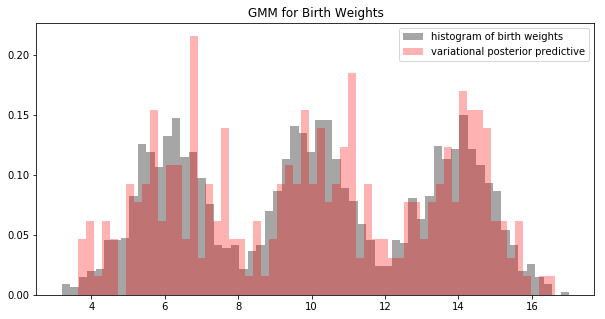

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist(y, bins=60, density=True, color='gray', alpha=0.7, label='histogram of birth weights')
posterior_predictive_samples = posterior_predictive_sampling(m_current, s_sq_current, 100)
ax.hist(posterior_predictive_samples, bins=60, density=True, color='red', alpha=0.3, label='variational posterior predictive')
ax.set_title('GMM for Birth Weights')
ax.legend(loc='best')
plt.show()

## Sanity Check: ELBO During Training

Remember that ploting the posterior predictive against actual data is not always an option (e.g. high-dimensional data).

A sanity check for that your CAVI algorithm has been implemented correctly is to plot the ELBO (or alternatively, the observed data log-likelihood) over the iterations of the algorithm:

$$
ELBO(\phi, m, s^2) = \mathbb{E}_{Z, \mu\sim q(Z, \mu | \phi, m, s^2)} \left[\log \left( \frac{p(Y_1, \ldots, Y_N, Z_1, \ldots, Z_N, \mu)}{q(Z, \mu | \phi, m, s^2)}\right) \right]
$$

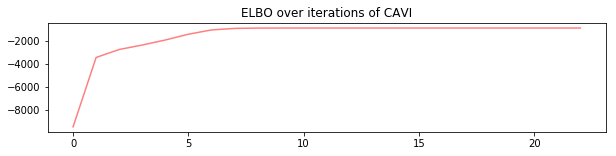

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2))
ax.plot(range(len(ELBOs)), ELBOs, color='red', alpha=0.5)
ax.set_title('ELBO over iterations of CAVI')
plt.show()